In [18]:
import torch
from torch import nn, optim
import numpy as np


In [15]:
class SurrogateNN(nn.Module):
    def __init__(self):
        super(SurrogateNN, self).__init__()
        
        self.input_dim = 2  # number of inputs. rn its at_junction and distance to junction
        self.hidden_dim = 10  # Number of hidden units.
        self.input_dim = 1 # acutally lets forget at_junction. if at_junction is True we will set distance to zero. 
        
        # Defining the layers
        self.layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, 1)  # Output dimension is 1.

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Use ReLU activation function for the hidden layer
        x = torch.sigmoid(self.layer2(x))  # Use sigmoid activation function for the output layer
        return x

In [46]:

# Set the random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Define the size of the dataset
n_samples = 10000

# Generate inputs between 0 and 10
inputs = np.random.uniform(0, 10, size=(n_samples, 1))

# Generate labels, more likely to be 1 for smaller inputs and 0 for larger inputs
labels = np.random.binomial(1, p=(10 - inputs) / 10.0).astype(np.float32) # Probability decreases with input

# Convert to PyTorch tensors
train_data = torch.from_numpy(inputs).float()
train_labels = torch.from_numpy(labels)

# Print some samples from the generated data
for i in range(10):
    print(f"Input: {inputs[i, 0]}, Label: {int(labels[i])}")

net = SurrogateNN()

# Define a loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification

# Define an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)  # Stochastic Gradient Descent

# # Training data and labels
# # Replace these with your actual data
# train_data = torch.randn(100, 1)  # 100 examples, each of 1-dimensional input
# train_labels = torch.randint(0, 2, (100,))  # 100 labels, either 0 or 1

# Training loop
epochs = 10000  # Number of training epochs
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    
    outputs = net(train_data)  # Forward pass
    loss = criterion(outputs.squeeze(), train_labels.squeeze())  # Compute loss
    
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Input: 5.4881350392732475, Label: 1
Input: 7.151893663724195, Label: 0
Input: 6.027633760716439, Label: 0
Input: 5.448831829968968, Label: 0
Input: 4.236547993389047, Label: 1
Input: 6.458941130666561, Label: 1
Input: 4.375872112626925, Label: 1
Input: 8.917730007820797, Label: 0
Input: 9.636627605010293, Label: 0
Input: 3.8344151882577773, Label: 0
Epoch 10/10000, Loss: 0.6756970286369324
Epoch 20/10000, Loss: 0.6716024875640869
Epoch 30/10000, Loss: 0.6684015989303589
Epoch 40/10000, Loss: 0.6653580069541931
Epoch 50/10000, Loss: 0.6623830795288086
Epoch 60/10000, Loss: 0.6594653129577637
Epoch 70/10000, Loss: 0.6566015481948853
Epoch 80/10000, Loss: 0.6537899374961853
Epoch 90/10000, Loss: 0.6510291695594788
Epoch 100/10000, Loss: 0.6483175754547119
Epoch 110/10000, Loss: 0.6456539630889893
Epoch 120/10000, Loss: 0.6430367231369019
Epoch 130/10000, Loss: 0.6404649019241333
Epoch 140/10000, Loss: 0.6379371285438538
Epoch 150/10000, Loss: 0.6354522705078125
Epoch 160/10000, Loss: 0.63

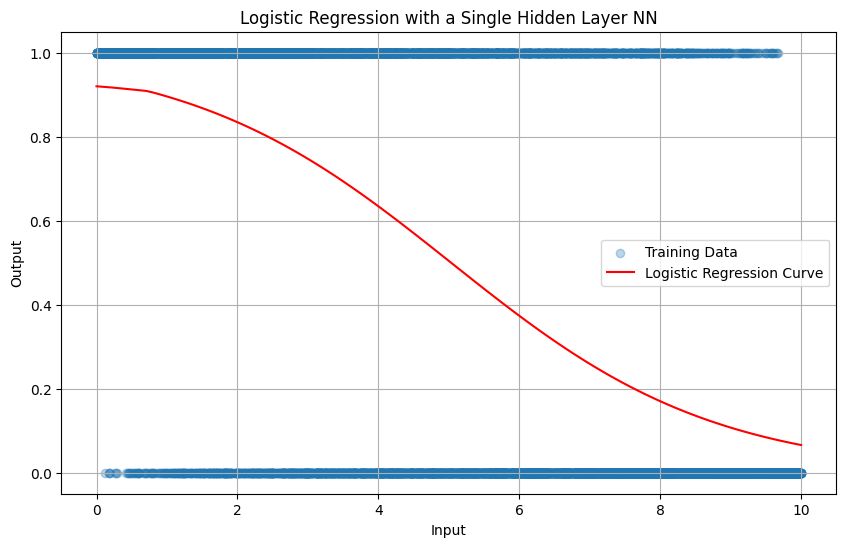

In [47]:
import matplotlib.pyplot as plt

# Ensure our network is in evaluation mode
net.eval()

# Generate a range of input values
input_values = torch.linspace(0, 10, 100).unsqueeze(1)

# Pass the input values through the network
with torch.no_grad():
    output_values = net(input_values)

# Convert tensors to numpy arrays for plotting
input_values = input_values.numpy()
output_values = output_values.numpy()

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(inputs, labels, alpha=0.3, label='Training Data')
plt.plot(input_values, output_values, color='red', label='Logistic Regression Curve')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Logistic Regression with a Single Hidden Layer NN')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
torch.save(net.state_dict(), "./saved_models/surrogate_model.pth")